### Analisis de Localidad

In [5]:
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import Queen
import rasterio
from rasterio.features import shapes
import pandas as pd
import numpy as np
import imageio.v2 as imageio 

In [16]:
amenazas = gpd.read_file("../data/processed/amenazas/amenaza_valdivia.shp")

In [ ]:
w = Queen.from_dataframe(amenazas)
moran = Moran(amenazas["gridcode"], w)

C:\Users\Carloto\AppData\Local\Temp\ipykernel_26548\1739040107.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(amenazas)
C:\Users\Carloto\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 58417.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 58417, ' is an island (no neighbors)')


In [4]:
print(f"I de Moran: {moran.I}, p-value: {moran.p_sim}")

I de Moran: 0.245773610545895, p-value: 0.001


In [5]:
src = rasterio.open("../data/processed/vegetacion_processed.tif")

In [6]:
resultados_formas = shapes(src.read(1), transform=src.transform)

# Crear GeoDataFrame
vegetacion = gpd.GeoDataFrame.from_features(
    [{'geometry': geom, 'properties': {'ndvi': val}} for geom, val in resultados_formas],
    crs=src.crs
)

In [7]:
w = Queen.from_dataframe(vegetacion)
moran = Moran(vegetacion["ndvi"], w)

C:\Users\Carloto\AppData\Local\Temp\ipykernel_26548\2546796185.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(vegetacion)


In [8]:
print(f"I de Moran: {moran.I}, p-value: {moran.p_sim}")

I de Moran: 0.9077192790247994, p-value: 0.001


In [9]:
src = rasterio.open("../data/processed/topologia_processed.tif")

resultados_formas = shapes(src.read(1), transform=src.transform)

# Crear GeoDataFrame
topologia = gpd.GeoDataFrame.from_features(
    [{'geometry': geom, 'properties': {'altura': val}} for geom, val in resultados_formas],
    crs=src.crs
)

In [10]:
w = Queen.from_dataframe(topologia)
moran = Moran(topologia["altura"], w)

C:\Users\Carloto\AppData\Local\Temp\ipykernel_26548\2604982556.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(topologia)


In [11]:
print(f"I de Moran: {moran.I}, p-value: {moran.p_sim}")

I de Moran: 0.9980011465206547, p-value: 0.001


#### Correlación entre variables

In [6]:
src = rasterio.open("../data/processed/topologia_processed.tif")
data = src.read(1)

### Simulación

In [7]:
import moderngl
import numpy as np
import matplotlib.pyplot as plt

tamano_grilla = data.shape

# Crea el contexto y el compute shader
ctx = moderngl.create_context(standalone=True)

compute = ctx.compute_shader(open("../src/shader/simular.glsl").read())

# Estados iniciales
estados = np.zeros(tamano_grilla, dtype=np.int32)
estados[tamano_grilla[0]//2, tamano_grilla[1]//2] = 1

# Genera los buffers para la simulación
buf_a = ctx.buffer(estados.tobytes())
buf_a.bind_to_storage_buffer(0)
buf_b = ctx.buffer(estados.tobytes())
buf_b.bind_to_storage_buffer(1)

def inicializar():
    global buf_a, buf_b
    estados = np.zeros(tamano_grilla, dtype=np.int32)
    estados[tamano_grilla[0]//2, tamano_grilla[1]//2] = 1
    buf_a = ctx.buffer(estados.tobytes())
    buf_a.bind_to_storage_buffer(0)
    buf_b = ctx.buffer(estados.tobytes())
    buf_b.bind_to_storage_buffer(1)

# Ejecuta un paso en la simulación
def paso():
    global buf_a, buf_b
    buf_a.bind_to_storage_buffer(0)
    buf_b.bind_to_storage_buffer(1)
    
    compute.run(group_x=tamano_grilla[0]//32, group_y=tamano_grilla[1]//32)
    ctx.memory_barrier(moderngl.SHADER_STORAGE_BARRIER_BIT)
    buf_a, buf_b = buf_b, buf_a

In [8]:
inicializar()

for i in range(200):
    paso()
    estado_incendio = np.reshape(np.frombuffer(buf_a.read(), dtype=np.int32), tamano_grilla)
    imagen = Image.fromarray(estado_incendio.astype(np.uint8))
    imagen.save(f"../outputs/maps/simulacion/{i}.png")

Iniciando simulación y generación de video...
✅ Datos estadísticos guardados en ../data/processed/stats_simulacion.csv


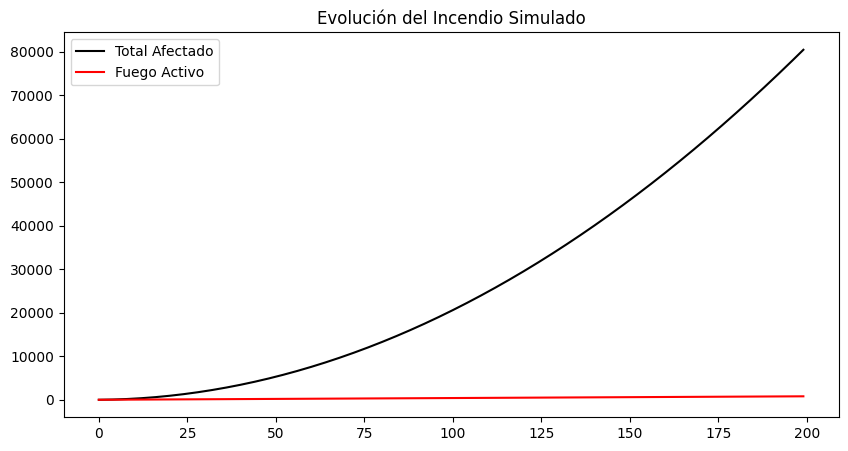

In [9]:
inicializar()

# Lista para guardar los datos del gráfico
historial_incendio = []

print("Iniciando simulación y generación de video...")


for i in range(200):
    paso()
    
    # 1. LEER ESTADO ACTUAL (0=arbol, 1=fuego, 2=ceniza)
    raw_buffer = np.frombuffer(buf_a.read(), dtype=np.int32)
    # Reformamos el buffer a la grilla de simulación
    grid_estado = np.reshape(raw_buffer, tamano_grilla)
    
    # 3. CALCULAR DATOS PARA EL GRÁFICO
    # Contamos celdas (no píxeles de imagen, sino celdas de simulación)
    celdas_fuego = np.sum(grid_estado == 1)
    celdas_quemadas = np.sum(grid_estado > 1) 
    total_afectado = celdas_fuego + celdas_quemadas
    
    historial_incendio.append({
        "Paso": i,
        "Fuego Activo": celdas_fuego,
        "Area Quemada": total_afectado
    })

# 4. GUARDAR DATOS EN CSV PARA MAIN.PY
df_simulacion = pd.DataFrame(historial_incendio)
# Asegúrate de que la carpeta exista o usa una ruta válida
csv_path = "../data/processed/stats_simulacion.csv"
df_simulacion.to_csv(csv_path, index=False)
print(f"✅ Datos estadísticos guardados en {csv_path}")

# Previsualización rápida
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df_simulacion["Paso"], df_simulacion["Area Quemada"], label="Total Afectado", color="black")
plt.plot(df_simulacion["Paso"], df_simulacion["Fuego Activo"], label="Fuego Activo", color="red")
plt.title("Evolución del Incendio Simulado")
plt.legend()
plt.show()